In [1]:
import numpy as np
import os
import sys
import collections
import matplotlib.pyplot as plt
import loompy
# import scipy.sparse as sparse
import urllib.request
import pybedtools
from pybedtools import BedTool
import warnings
# from sklearn.neighbors import NearestNeighbors
import statsmodels as sm
from statsmodels.sandbox.stats.multicomp import multipletests
from statsmodels.stats.proportion import proportions_ztest
from numba import jit
import numba

sys.path.append('/home/camiel/chromograph/')
# from chromograph.plotting.UMI_plot import UMI_plot
import chromograph
from chromograph.peak_calling.utils import *

import cytograph as cg

from umap import UMAP
import sklearn.metrics
from scipy.spatial import distance
import community
import networkx as nx
from scipy import sparse
from typing import *

import logging
logger = logging.getLogger()
logging.basicConfig(
    format='%(asctime)s %(levelname)-8s %(message)s',
    level=logging.INFO,
    datefmt='%H:%M:%S')

In [2]:
## Connect to file

f = '/data/proj/scATAC/chromograph/build_20191206/Cerebellum.loom'
ref = '/data/ref/cellranger-atac/refdata-cellranger-atac-GRCh38-1.2.0/'
ds = loompy.connect(f)
print(ds.shape)
blayer = str(int(ds.attrs['bin_size']/1000)) + 'kb_bins'

(617643, 17811)


(0, 6.5)

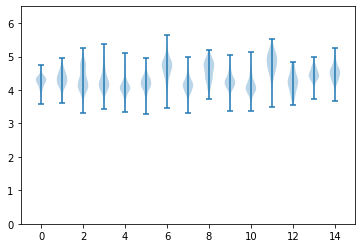

In [3]:
pos = np.unique(ds.ca['Clusters'])
data = [np.log10(ds.ca['passed_filters'][ds.ca['Clusters'] == x]) for x in pos]

plt.violinplot(data, pos)
plt.ylim((0,6.5))

In [ ]:
## Aggregrate bins
Clus = np.unique(ds.ca['Clusters'])
Csum = []

for x in Clus:
    logging.info(f"Computing sum cluster {x}")
    cells = ds.ca['Clusters'] == x
    Csum.append(np.sum(ds[blayer][:,cells], axis=1))

17:03:39 INFO     Computing sum cluster 0
17:07:06 INFO     Computing sum cluster 1
17:08:40 INFO     Computing sum cluster 2


In [ ]:
from statsmodels.stats.proportion import proportions_ztest

Zarr = []
Parr = []

for clus in Clus:
    zscore = []
    pval = []

#     fac = np.mean(ds.ca['NBins'][ds.ca['Clusters'] == clus]) / np.mean(ds.ca['NBins'][ds.ca['Clusters'] == clus])

#     n1 = sum(ds.ca['Clusters'] == clus) / fac
    n1 = sum(ds.ca['Clusters'] == clus)
    n2 = ds.shape[1] - n1

    for x in range(ds.shape[0]):
        ## Get success rates
        s1 = Csum[clus][x]
        s2 = ds.ra['NCells'][x] - s1

        if np.logical_or(s1, s2):
            ## Get zscore and p-value
            z,p = proportions_ztest([s1, s2], [n1, n2], alternative='larger')
            zscore.append(z)
            pval.append(p)
        else:
            zscore.append(0)
            pval.append(1)
    
    (_, q, _, _) = multipletests(pval, 0.1, method="fdr_bh")
    Zarr.append(zscore)
    Parr.append(q)
    logging.info(f"Enrichment calculated for cluster {clus}")
    
Zarr = np.array(Zarr).T
Parr = np.array(Parr).T

ds.ra['Zscore'] = Zarr
ds.ra['Pval_Zscore'] = Parr

In [ ]:
sigBins = []

quant = 100 / ds.shape[0]
for clus in Clus:
    lim = min(np.quantile(ds.ra['Pval_Zscore'][:,clus], quant), 0.05)
    print(lim)
    x = ds.ra['Pval_Zscore'][:,clus] < lim
    sigBins.append(x)
sigBins = np.array(sigBins).T

(-7.152232807027642, 10.929795658524943, -11.4724097248669, 10.652942180311236)

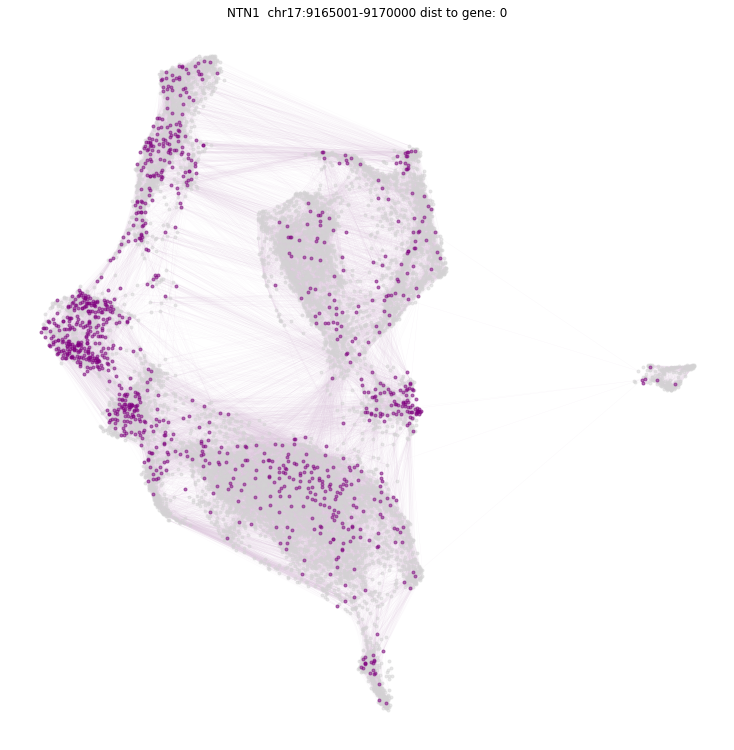

In [8]:
from cytograph.plotting.colors import *
from matplotlib.collections import LineCollection

emb = 'UMAP'
ID = 531186
pos = ds.ca[emb]

b = ds.ra['ID'] == ID
k = (ds[b,:] > 0).flatten()
v = ds[blayer][b,:].flatten()


g = ds.col_graphs.RNN
has_edges = True

# Compute a good size for the markers, based on local density
min_pts = 50
eps_pct = 60

knn = ds.col_graphs['KNN']
k_radius = knn.max(axis=1).toarray()
epsilon = (250 / (pos.max() - pos.min())) * np.percentile(k_radius, eps_pct)

fig = plt.figure(figsize=(25, 10))
ax = fig.add_axes([0, 0, 0.4, 1])

lc = LineCollection(zip(pos[g.row], pos[g.col]), linewidths=0.25, zorder=0, color='thistle', alpha=0.1)
ax.add_collection(lc)

ax.scatter(pos[:,0], pos[:,1],s=epsilon, c = 'lightgrey', alpha=.5)
ax.scatter(pos[k,0], pos[k,1],s=epsilon, c = 'purple', alpha=.5)
ax.set_title(f"{ds.ra['Gene'][b][0]}  {ds.ra['chrom'][b][0]}:{ds.ra['start'][b][0]}-{ds.ra['end'][b][0]} dist to gene: {ds.ra['Distance'][b][0]}")

ax.axis("off")

(-7.11655692373449,
 10.928096806939555,
 -11.473378274657527,
 10.673281725914443)

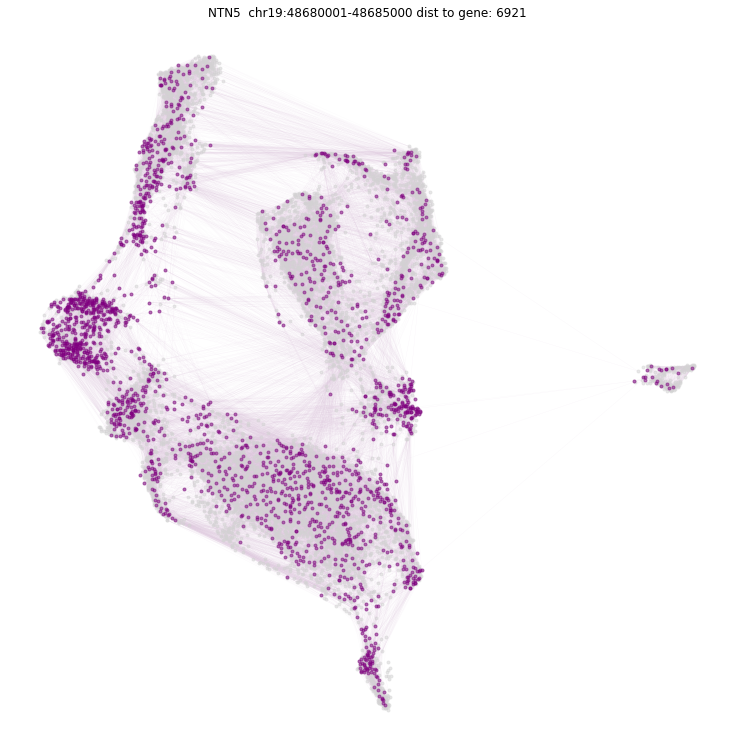

In [609]:
from cytograph.plotting.colors import *
from matplotlib.collections import LineCollection

emb = 'UMAP'
ID = 584702
pos = ds.ca[emb]

b = ds.ra['ID'] == ID
k = (ds[b,:] > 0).flatten()
v = ds[blayer][b,:].flatten()


g = ds.col_graphs.RNN
has_edges = True

# Compute a good size for the markers, based on local density
min_pts = 50
eps_pct = 60

knn = ds.col_graphs['KNN']
k_radius = knn.max(axis=1).toarray()
epsilon = (250 / (pos.max() - pos.min())) * np.percentile(k_radius, eps_pct)

fig = plt.figure(figsize=(25, 10))
ax = fig.add_axes([0, 0, 0.4, 1])

lc = LineCollection(zip(pos[g.row], pos[g.col]), linewidths=0.25, zorder=0, color='thistle', alpha=0.1)
ax.add_collection(lc)

ax.scatter(pos[:,0], pos[:,1],s=epsilon, c = 'lightgrey', alpha=.5)
ax.scatter(pos[k,0], pos[k,1],s=epsilon, c = 'purple', alpha=.5)
ax.set_title(f"{ds.ra['Gene'][b][0]}  {ds.ra['chrom'][b][0]}:{ds.ra['start'][b][0]}-{ds.ra['end'][b][0]} dist to gene: {ds.ra['Distance'][b][0]}")

ax.axis("off")

(-7.115926706727459, 10.94292947565252, -11.4724097248669, 10.652942180311236)

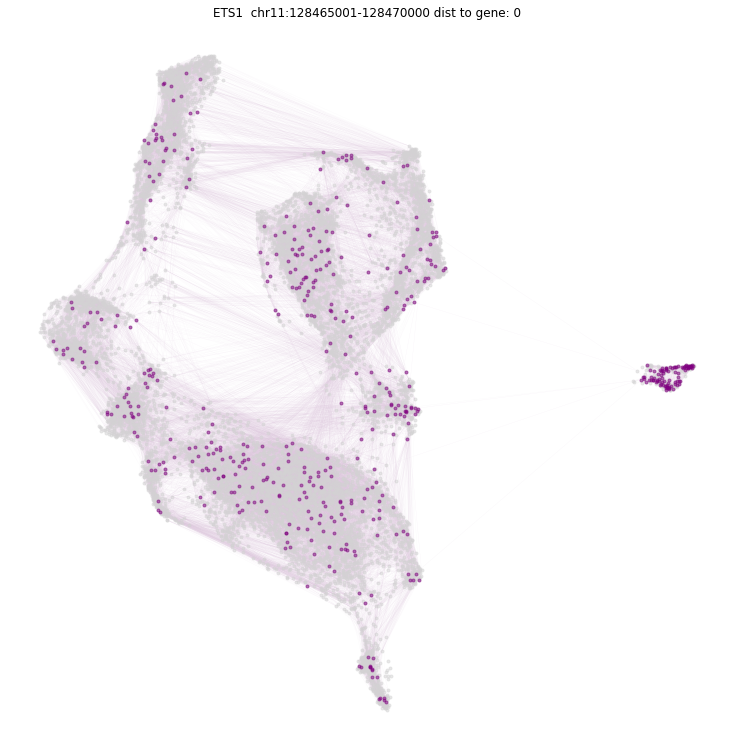

In [610]:
from cytograph.plotting.colors import *
from matplotlib.collections import LineCollection

emb = 'UMAP'
ID = 391875
pos = ds.ca[emb]

b = ds.ra['ID'] == ID
k = (ds[b,:] > 0).flatten()
v = ds[blayer][b,:].flatten()


g = ds.col_graphs.RNN
has_edges = True

# Compute a good size for the markers, based on local density
min_pts = 50
eps_pct = 60

knn = ds.col_graphs['KNN']
k_radius = knn.max(axis=1).toarray()
epsilon = (250 / (pos.max() - pos.min())) * np.percentile(k_radius, eps_pct)

fig = plt.figure(figsize=(25, 10))
ax = fig.add_axes([0, 0, 0.4, 1])

lc = LineCollection(zip(pos[g.row], pos[g.col]), linewidths=0.25, zorder=0, color='thistle', alpha=0.1)
ax.add_collection(lc)

ax.scatter(pos[:,0], pos[:,1],s=epsilon, c = 'lightgrey', alpha=.5)
ax.scatter(pos[k,0], pos[k,1],s=epsilon, c = 'purple', alpha=.5)
ax.set_title(f"{ds.ra['Gene'][b][0]}  {ds.ra['chrom'][b][0]}:{ds.ra['start'][b][0]}-{ds.ra['end'][b][0]} dist to gene: {ds.ra['Distance'][b][0]}")

ax.axis("off")

In [2]:
from cytograph.plotting.colors import *
from matplotlib.collections import LineCollection

emb = 'UMAP'
gene = 'ETS1'
pos = ds.ca[emb]

b = np.logical_and(ds.ra['Gene'] == gene, ds.ra['Distance'] == 0)
nz = np.sum(ds[blayer][b,:], axis=0)
nz = nz / (ds.ca['passed_filters']/1000000)
k = nz > 0
v = nz[nz > 0]

logging.info(f"Total of {sum(b)} bins")

g = ds.col_graphs.RNN
has_edges = True

# Compute a good size for the markers, based on local density
min_pts = 50
eps_pct = 60

knn = ds.col_graphs['KNN']
k_radius = knn.max(axis=1).toarray()
epsilon = (250 / (pos.max() - pos.min())) * np.percentile(k_radius, eps_pct)

fig = plt.figure(figsize=(25, 10))
ax = fig.add_axes([0, 0, 0.4, 1])

lc = LineCollection(zip(pos[g.row], pos[g.col]), linewidths=0.25, zorder=0, color='thistle', alpha=0.1)
ax.add_collection(lc)

ax.scatter(pos[:,0], pos[:,1],s=epsilon, c = 'lightgrey', alpha=.5)
im = ax.scatter(pos[k,0], pos[k,1],s=epsilon, c = v, cmap = 'viridis', alpha=.5)
fig.colorbar(im, ax=ax)
ax.set_title(f"{gene}  whole range")

ax.axis("off")

KeyboardInterrupt: 

In [19]:
g = ds.col_graphs['MKNN'].toarray()
vals = []
x = 0

%timeit nn = g[:,x]>0
%timeit nn_n = sum(nn)
%timeit v = ds[blayer][:,x] + np.sum(ds[blayer][:,nn], axis=1) / (nn_n+1)
vals.append(v)
    

90.9 µs ± 207 ns per loop (mean ± std. dev. of 7 runs, 10000 loops each)
18.5 ms ± 45.3 µs per loop (mean ± std. dev. of 7 runs, 100 loops each)
2.7 s ± 26.9 ms per loop (mean ± std. dev. of 7 runs, 1 loop each)


In [632]:
def smooth_bins(ds: loompy.LoomConnection, graph = 'MKNN') -> None:
    '''
    '''
    g = ds.col_graphs[graph].toarray()
    vals = []
#     for x in range(ds.shape[1]):
    for x in range(5):
        nn = g[:,x]>0
        nn_n = sum(nn)
        v = ds[blayer][:,x] + np.sum(ds[blayer][:,nn], axis=1) / (nn_n+1)
        vals.append(v)

        logging.info(f"Finished {x}")
            
    return np.vstack(vals).T
    

In [16]:
from numba import jit
import numba

# Parallel version
@jit(nopython=True, parallel=True)
def smooth_bins_jit(data, g) -> None:
    '''
    '''
    vals = []
    for x in numba.prange(data.shape[1]):
        nn = g[:,x]>0
        nn_n = np.sum(nn)
        v = data[:,x] + np.sum(data[:,nn], axis=1) / (nn_n+1)
        vals.append(v)
        
    return vals


In [ ]:
g = ds.col_graphs['MKNN'].toarray()
smooth = []
batch = 100
i = 0

# vals = smooth_bins_jit(ds[blayer][:,:], g)

for (ix, selection, view) in ds.scan(axis=0, batch_size=batch):
    g = view.col_graphs['MKNN'].toarray()
    vals = smooth_bins_jit(view[blayer][:,:], g)
    vals = np.array(vals)
    smooth.append(vals)
    i+= batch
    if i% (batch*10) == 0:
        logging.info(f"finished{i} rows")


In [31]:
smooth[0].shape

(5, 10000)

In [679]:
# nnz = []

# for i in range(0,ds.shape[1], 100):
#     if i + 100 > ds.shape[1]:
#         nnz.append(np.array(ds[blayer][:,i:] > 0))
        
#     else:
#         nnz.append(np.array(ds[blayer][:,i:(i+100)] > 0))
#     if i%1000 == 0:
#         logging.info(i)
# nnz = np.hstack(nnz)
# nnz.dtype = 'int8'

10:40:14 INFO     0
10:40:35 INFO     1000
10:40:54 INFO     2000
10:41:15 INFO     3000
10:41:36 INFO     4000
10:41:55 INFO     5000
10:42:17 INFO     6000
10:42:38 INFO     7000
10:42:57 INFO     8000
10:43:16 INFO     9000


ValueError: all the input array dimensions for the concatenation axis must match exactly, but along dimension 1, the array at index 0 has size 100 and the array at index 94 has size 70

In [8]:
genes = BedTool(os.path.join(ref, 'genes', 'genes.gtf'))

coding = []
for x in genes:
    if np.logical_and(x['gene_type'] == 'protein_coding', x[2] == 'gene'):
        coding.append(x)
coding = BedTool(coding)

bins = np.stack([ds.ra['chrom'], ds.ra['start'], ds.ra['end'], ds.ra['ID']]).T.tolist()
bins = BedTool(bins)

annot = bins.sort().closest(coding.sort(), d=True, t='first')
an_dict = {'Accession': [], 'Gene': [], 'Distance': [], 'ID': []}

for x in annot:
    feats = x[12].split(';')[:-1]
    feats = [x.split(' ') for x in feats]
    feats = {k:v for k,v in feats}
    if int(x[13]) > 10000:
        an_dict['Accession'].append('-')
        an_dict['Gene'].append('intergenic')
        an_dict['Distance'].append(0)
        an_dict['ID'].append(int(x[3]))   
    else:
        an_dict['Accession'].append(feats['gene_id'].strip('"'))
        an_dict['Gene'].append(feats['gene_name'].strip('"'))
        an_dict['Distance'].append(int(x[13]))
        an_dict['ID'].append(int(x[3]))
an_dict = {x: np.array(an_dict[x]) for x in an_dict}
an_dict = {x: an_dict[x][an_dict['ID'].argsort()] for x in an_dict}

for x in ['Accession', 'Gene', 'Distance']:
    ds.ra[x] = an_dict[x]

In [4]:
sigGenes = []
for clus in Clus:
    sigGenes.append(np.vstack((ds.ra['ID'][sigBins[:,clus]], ds.ra['Gene'][sigBins[:,clus]], np.round(Zarr[:,clus]))).T)
[print(k,v) for k,v in enumerate(sigGenes)]